In [325]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_6504/1115248133.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_6504/1115248133.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2020-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


In [326]:
def predict_mean_reversion_label(spread, window, threshold):
    labels = []
    mean = spread.mean()

    for i in range(len(spread)):
        future_spread = spread[i + 1 : i + 1 + window]
        if len(future_spread) < window:
            labels.append(np.nan)
        elif any(abs(j - mean) < threshold for j in future_spread):
            labels.append(1)
        else:
            labels.append(0)

    return pd.Series(labels, index = spread.index)

In [327]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def create_features(spread, pair, window = 5):
    df = pd.DataFrame({'spread': spread})
    df['z-score'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['rolling_std'] = df['spread'].rolling(window).std()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

optimal_window_threshold = {'IEMG_EEM': {'window': 5, 'threshold': 0.005},
                            'ARKK_ARKW': {'window': 5, 'threshold': 0.02},
                            'TLT_SPTL': {'window': 3, 'threshold': 0.003},
                            'SHY_VGSH': {'window': 3, 'threshold': 0.003},
                            'SOXX_ITA': {'window': 10, 'threshold': 0.01}
}

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    window = optimal_window_threshold[pair_name]['window']

    threshold = optimal_window_threshold[pair_name]['threshold']

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, pair_name, window = window)
    test_features = create_features(testing_spread, pair_name, window = window)

    train_labels = predict_mean_reversion_label(training_spread, window = window, threshold = threshold)
    train_features['label'] = train_labels.loc[train_features.index]
    train_features = train_features.dropna(subset=['label'])

    test_labels = predict_mean_reversion_label(testing_spread, window = window, threshold = threshold)
    test_features['label'] = test_labels.loc[test_features.index]
    test_features = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name] = test_features.drop(columns=['label'])
    y_test_dict[pair_name] = test_features['label']


training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [328]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [329]:
class ClassificationLSTM(nn.Module):
    def __init__(self, input_size = 7, hidden_size = 50, num_layers = 1):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        # out = self.sigmoid(out)
        return out.squeeze()

In [330]:
def train_model(model, train_loader, criterion, optimizer, epochs = 50, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [331]:
def evaluate_model(model, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy:", accuracy)
    return y_true, y_pred, y_pred_label

In [332]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x=aligned_spread.index, y=aligned_spread.values, label='Spread', color='black')
    sns.scatterplot(x=predicted_points.index, y=predicted_points.values, color='green', label='Predicted Reversion', s=100, marker='o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [333]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [334]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [335]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, window_size, epochs, device='cpu'):
    
    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype=torch.float32)
    y_train = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([len(y_train) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)
    
    model = ClassificationLSTM(input_size = 7).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs=epochs, device=device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, test_loader, device=device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred


Training model for pair: IEMG_EEM
Epoch 1/30 - Loss: 1.1010
Epoch 2/30 - Loss: 1.0708
Epoch 3/30 - Loss: 1.0508
Epoch 4/30 - Loss: 1.0331
Epoch 5/30 - Loss: 1.0164
Epoch 6/30 - Loss: 0.9990
Epoch 7/30 - Loss: 0.9794
Epoch 8/30 - Loss: 0.9563
Epoch 9/30 - Loss: 0.9302
Epoch 10/30 - Loss: 0.9036
Epoch 11/30 - Loss: 0.8800
Epoch 12/30 - Loss: 0.8604
Epoch 13/30 - Loss: 0.8445
Epoch 14/30 - Loss: 0.8316
Epoch 15/30 - Loss: 0.8216
Epoch 16/30 - Loss: 0.8136
Epoch 17/30 - Loss: 0.8073
Epoch 18/30 - Loss: 0.8022
Epoch 19/30 - Loss: 0.7981
Epoch 20/30 - Loss: 0.7948
Epoch 21/30 - Loss: 0.7920
Epoch 22/30 - Loss: 0.7897
Epoch 23/30 - Loss: 0.7877
Epoch 24/30 - Loss: 0.7860
Epoch 25/30 - Loss: 0.7845
Epoch 26/30 - Loss: 0.7831
Epoch 27/30 - Loss: 0.7819
Epoch 28/30 - Loss: 0.7808
Epoch 29/30 - Loss: 0.7798
Epoch 30/30 - Loss: 0.7788

Evaluating model for pair: IEMG_EEM
Test Accuracy: 0.6234309623430963


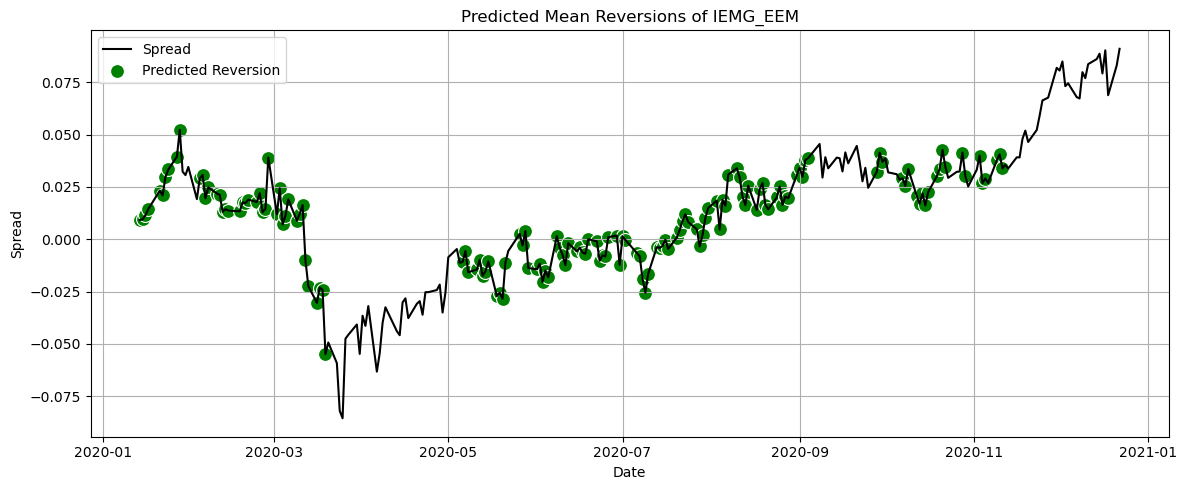

Confusion Matrix:
[[85 86]
 [ 4 64]]
F1 Score: 0.5872

Training model for pair: ARKK_ARKW
Epoch 1/30 - Loss: 1.1254
Epoch 2/30 - Loss: 1.0982
Epoch 3/30 - Loss: 1.0764
Epoch 4/30 - Loss: 1.0562
Epoch 5/30 - Loss: 1.0376
Epoch 6/30 - Loss: 1.0200
Epoch 7/30 - Loss: 1.0015
Epoch 8/30 - Loss: 0.9800
Epoch 9/30 - Loss: 0.9554
Epoch 10/30 - Loss: 0.9297
Epoch 11/30 - Loss: 0.9055
Epoch 12/30 - Loss: 0.8848
Epoch 13/30 - Loss: 0.8681
Epoch 14/30 - Loss: 0.8551
Epoch 15/30 - Loss: 0.8452
Epoch 16/30 - Loss: 0.8379
Epoch 17/30 - Loss: 0.8326
Epoch 18/30 - Loss: 0.8287
Epoch 19/30 - Loss: 0.8257
Epoch 20/30 - Loss: 0.8234
Epoch 21/30 - Loss: 0.8215
Epoch 22/30 - Loss: 0.8198
Epoch 23/30 - Loss: 0.8183
Epoch 24/30 - Loss: 0.8169
Epoch 25/30 - Loss: 0.8156
Epoch 26/30 - Loss: 0.8145
Epoch 27/30 - Loss: 0.8135
Epoch 28/30 - Loss: 0.8126
Epoch 29/30 - Loss: 0.8117
Epoch 30/30 - Loss: 0.8109

Evaluating model for pair: ARKK_ARKW
Test Accuracy: 0.4225941422594142


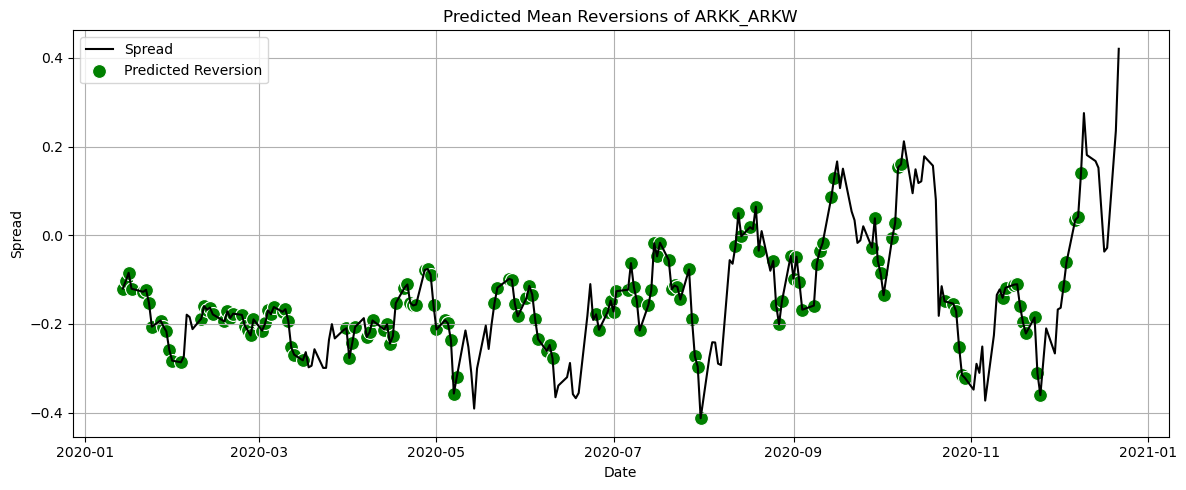

Confusion Matrix:
[[ 54 110]
 [ 28  47]]
F1 Score: 0.4052

Training model for pair: TLT_SPTL
Epoch 1/30 - Loss: 1.1811
Epoch 2/30 - Loss: 1.1618
Epoch 3/30 - Loss: 1.1484
Epoch 4/30 - Loss: 1.1366
Epoch 5/30 - Loss: 1.1257
Epoch 6/30 - Loss: 1.1143
Epoch 7/30 - Loss: 1.1012
Epoch 8/30 - Loss: 1.0857
Epoch 9/30 - Loss: 1.0678
Epoch 10/30 - Loss: 1.0488
Epoch 11/30 - Loss: 1.0311
Epoch 12/30 - Loss: 1.0162
Epoch 13/30 - Loss: 1.0041
Epoch 14/30 - Loss: 0.9943
Epoch 15/30 - Loss: 0.9861
Epoch 16/30 - Loss: 0.9794
Epoch 17/30 - Loss: 0.9737
Epoch 18/30 - Loss: 0.9689
Epoch 19/30 - Loss: 0.9648
Epoch 20/30 - Loss: 0.9614
Epoch 21/30 - Loss: 0.9585
Epoch 22/30 - Loss: 0.9560
Epoch 23/30 - Loss: 0.9537
Epoch 24/30 - Loss: 0.9518
Epoch 25/30 - Loss: 0.9501
Epoch 26/30 - Loss: 0.9485
Epoch 27/30 - Loss: 0.9471
Epoch 28/30 - Loss: 0.9458
Epoch 29/30 - Loss: 0.9446
Epoch 30/30 - Loss: 0.9435

Evaluating model for pair: TLT_SPTL
Test Accuracy: 0.36213991769547327


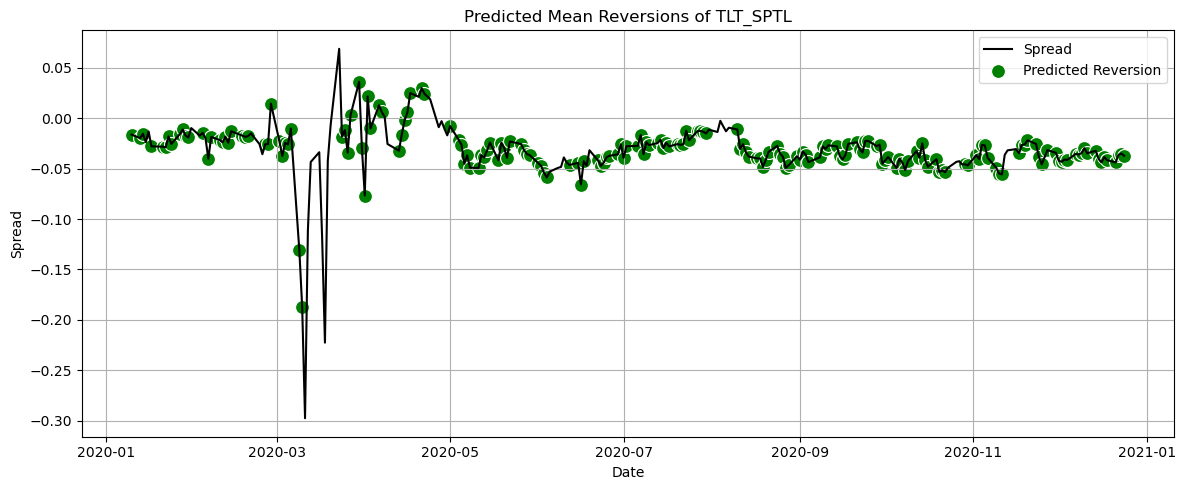

Confusion Matrix:
[[ 34 143]
 [ 12  54]]
F1 Score: 0.4106

Training model for pair: SHY_VGSH
Epoch 1/30 - Loss: 1.2533
Epoch 2/30 - Loss: 1.2193
Epoch 3/30 - Loss: 1.1938
Epoch 4/30 - Loss: 1.1733
Epoch 5/30 - Loss: 1.1594
Epoch 6/30 - Loss: 1.1505
Epoch 7/30 - Loss: 1.1424
Epoch 8/30 - Loss: 1.1329
Epoch 9/30 - Loss: 1.1225
Epoch 10/30 - Loss: 1.1118
Epoch 11/30 - Loss: 1.1014
Epoch 12/30 - Loss: 1.0912
Epoch 13/30 - Loss: 1.0810
Epoch 14/30 - Loss: 1.0707
Epoch 15/30 - Loss: 1.0606
Epoch 16/30 - Loss: 1.0514
Epoch 17/30 - Loss: 1.0434
Epoch 18/30 - Loss: 1.0368
Epoch 19/30 - Loss: 1.0313
Epoch 20/30 - Loss: 1.0269
Epoch 21/30 - Loss: 1.0233
Epoch 22/30 - Loss: 1.0206
Epoch 23/30 - Loss: 1.0184
Epoch 24/30 - Loss: 1.0166
Epoch 25/30 - Loss: 1.0151
Epoch 26/30 - Loss: 1.0138
Epoch 27/30 - Loss: 1.0127
Epoch 28/30 - Loss: 1.0117
Epoch 29/30 - Loss: 1.0107
Epoch 30/30 - Loss: 1.0098

Evaluating model for pair: SHY_VGSH
Test Accuracy: 0.5843621399176955


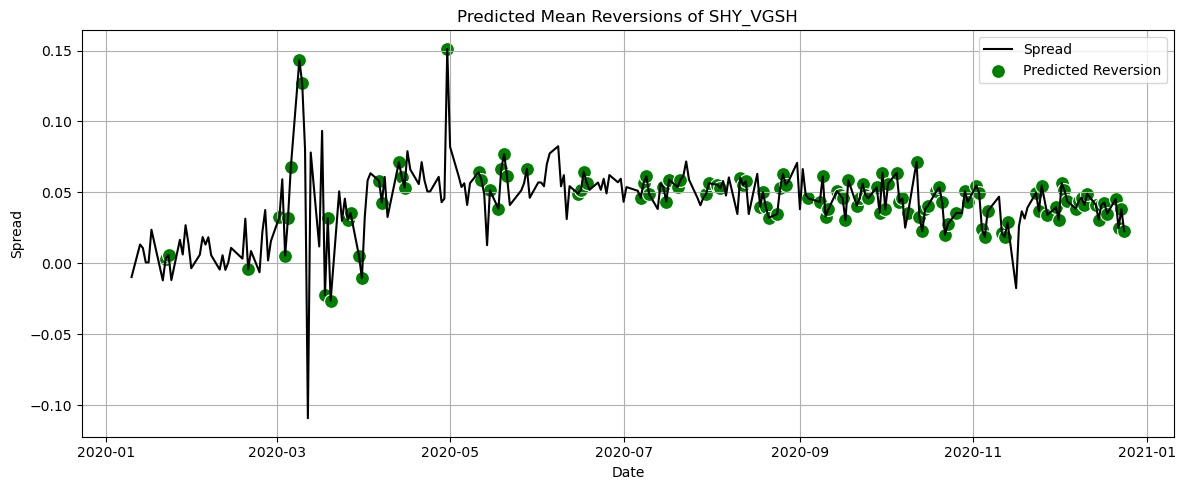

Confusion Matrix:
[[88 72]
 [29 54]]
F1 Score: 0.5167

Training model for pair: SOXX_ITA
Epoch 1/30 - Loss: 1.1366
Epoch 2/30 - Loss: 1.1152
Epoch 3/30 - Loss: 1.1019
Epoch 4/30 - Loss: 1.0907
Epoch 5/30 - Loss: 1.0802
Epoch 6/30 - Loss: 1.0695
Epoch 7/30 - Loss: 1.0574
Epoch 8/30 - Loss: 1.0437
Epoch 9/30 - Loss: 1.0281
Epoch 10/30 - Loss: 1.0111
Epoch 11/30 - Loss: 0.9940
Epoch 12/30 - Loss: 0.9781
Epoch 13/30 - Loss: 0.9643
Epoch 14/30 - Loss: 0.9530
Epoch 15/30 - Loss: 0.9440
Epoch 16/30 - Loss: 0.9369
Epoch 17/30 - Loss: 0.9313
Epoch 18/30 - Loss: 0.9268
Epoch 19/30 - Loss: 0.9230
Epoch 20/30 - Loss: 0.9198
Epoch 21/30 - Loss: 0.9170
Epoch 22/30 - Loss: 0.9145
Epoch 23/30 - Loss: 0.9122
Epoch 24/30 - Loss: 0.9101
Epoch 25/30 - Loss: 0.9082
Epoch 26/30 - Loss: 0.9063
Epoch 27/30 - Loss: 0.9045
Epoch 28/30 - Loss: 0.9029
Epoch 29/30 - Loss: 0.9013
Epoch 30/30 - Loss: 0.8997

Evaluating model for pair: SOXX_ITA
Test Accuracy: 0.9388646288209607


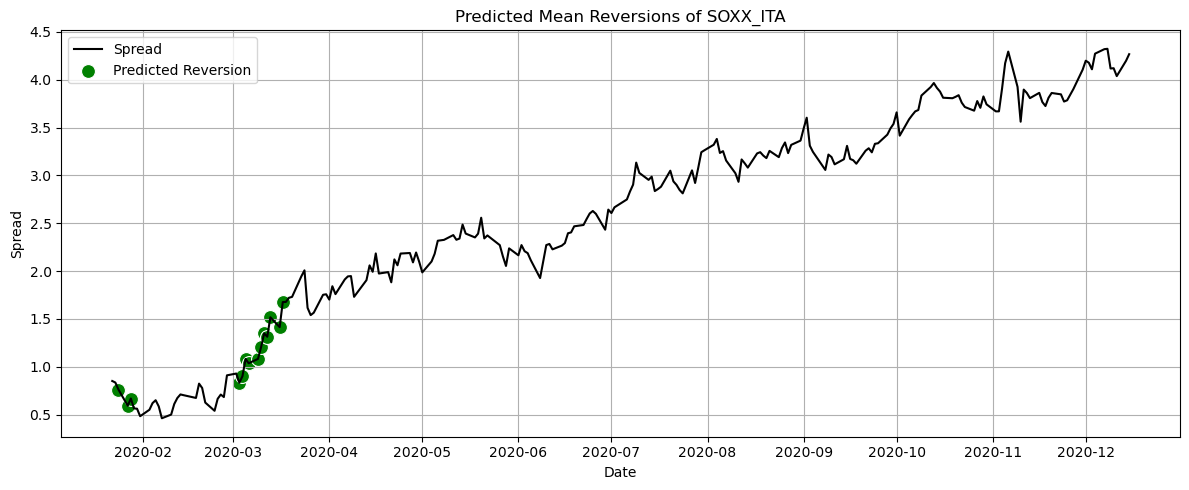

Confusion Matrix:
[[215  14]
 [  0   0]]
F1 Score: 0.0000
{'IEMG_EEM': {'model': ClassificationLSTM(
  (lstm): LSTM(7, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
    

In [336]:
results = {}


for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        window_size = 3,
        epochs = 30,
        device='cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)